In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [15]:
# Load and preprocess dataset
df_rev = pd.read_csv('yelp.csv')
df_rev = df_rev.dropna()
df_rev['binary_rating'] = np.where(df_rev['stars'] > 3, 1, 0)

In [16]:
# Balance the dataset
positive = df_rev[df_rev['binary_rating'] == 1]
negative = df_rev[df_rev['binary_rating'] == 0]
max_count = min(len(positive), len(negative))
balanced_df = pd.concat([positive.sample(n=max_count), negative.sample(n=max_count)])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    balanced_df['text'], balanced_df['binary_rating'], test_size=0.2, random_state=42
)

In [18]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
train_padded = pad_sequences(train_sequences, maxlen=300, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=300, padding='post', truncating='post')

In [19]:


# Save the tokenizer
joblib.dump(tokenizer, 'tokenizer2.joblib')


['tokenizer2.joblib']

In [7]:
# Build the RNN model
model = Sequential([
    Embedding(input_dim=5001, output_dim=128, input_length=300),
    Bidirectional(SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\Rana Comuter\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [30]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_padded, train_labels, epochs=20, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 50s 398ms/step - accuracy: 0.5231 - loss: 0.6928 - val_accuracy: 0.4841 - val_loss: 0.6950
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - accuracy: 0.5016 - loss: 0.6948 - val_accuracy: 0.4681 - val_loss: 0.6975
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.5015 - loss: 0.6941 - val_accuracy: 0.5120 - val_loss: 0.6930
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.4997 - loss: 0.6944 - val_accuracy: 0.4950 - val_loss: 0.6933
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 33s 262ms/step - accuracy: 0.5244 - loss: 0.6920 - val_accuracy: 0.4811 - val_loss: 0.6960
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.5004 - loss: 0.6949 - val_accuracy: 0.4831 - val_loss: 0.6951


In [31]:
# Evaluate model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5146 - loss: 0.6924
Test Accuracy: 0.5219123363494873


In [32]:
# Classification report
test_predictions = model.predict(test_padded)
binary_predictions = (test_predictions > 0.5).astype(int)
print(classification_report(test_labels, binary_predictions))

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       631
           1       0.52      0.51      0.52       624

    accuracy                           0.52      1255
   macro avg       0.52      0.52      0.52      1255
weighted avg       0.52      0.52      0.52      1255



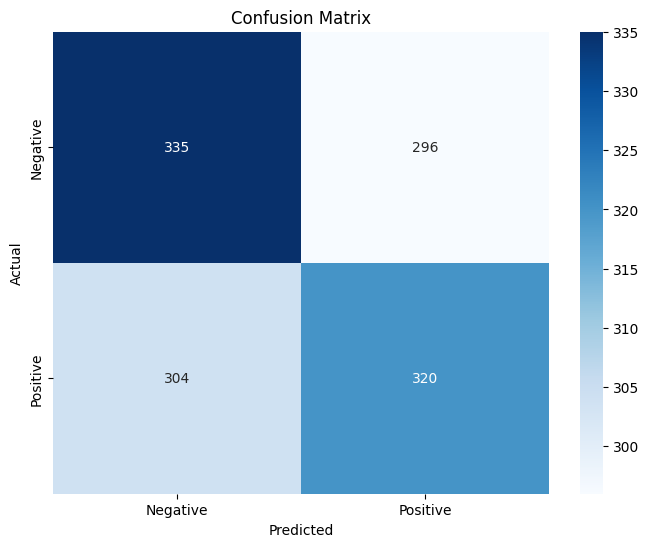

In [33]:
# Confusion matrix
confusion_mtx = confusion_matrix(test_labels, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [34]:
# Save the model
model.save('rnn_sentiment_model5.h5')
